# Определение стоимости автомобилей

**Данные**

База данных с техническими характеристиками, комплектациями и ценами автомобилей

**Задача**

Построить модель для определения стоимости.  
Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

In [1]:
import pandas as pd
import numpy as np
import random

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor

## Подготовка данных

### Загрузка данных

In [680]:
data = pd.read_csv('/datasets/autos.csv')
data.head(2)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50


In [596]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Данные содержат пропуски

### Дубликаты строк

In [597]:
data.duplicated().sum()

4

In [598]:
# Удаляю дубликаты

data = data.drop_duplicates()
len(data)

354365

### Даты

Конвертирую в категориальный признак по аналогии с уже существующими столбцами `RegistrationYear`, `RegistrationMonth`.<br>
Из каждого столбца с датой создаю 2 столбца: Год и Месяц.

In [599]:
dates = ['DateCrawled', 'DateCreated', 'LastSeen']
for col in dates:
    data[col] = pd.to_datetime(data[col], format='%Y-%m-%d %H:%M:%S')
    data[col+'_year'] = data[col].dt.year
    data[col+'_month'] = data[col].dt.month   
    
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,...,DateCreated,NumberOfPictures,PostalCode,LastSeen,DateCrawled_year,DateCrawled_month,DateCreated_year,DateCreated_month,LastSeen_year,LastSeen_month
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,...,2016-03-24,0,70435,2016-04-07 03:16:57,2016,3,2016,3,2016,4
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,...,2016-03-24,0,66954,2016-04-07 01:46:50,2016,3,2016,3,2016,4
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,...,2016-03-14,0,90480,2016-04-05 12:47:46,2016,3,2016,3,2016,4
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,...,2016-03-17,0,91074,2016-03-17 17:40:17,2016,3,2016,3,2016,3
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,...,2016-03-31,0,60437,2016-04-06 10:17:21,2016,3,2016,3,2016,4


In [600]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354365 entries, 0 to 354368
Data columns (total 22 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354365 non-null  datetime64[ns]
 1   Price              354365 non-null  int64         
 2   VehicleType        316875 non-null  object        
 3   RegistrationYear   354365 non-null  int64         
 4   Gearbox            334532 non-null  object        
 5   Power              354365 non-null  int64         
 6   Model              334660 non-null  object        
 7   Kilometer          354365 non-null  int64         
 8   RegistrationMonth  354365 non-null  int64         
 9   FuelType           321470 non-null  object        
 10  Brand              354365 non-null  object        
 11  Repaired           283211 non-null  object        
 12  DateCreated        354365 non-null  datetime64[ns]
 13  NumberOfPictures   354365 non-null  int64   

### Brand

In [693]:
data.Brand.sort_values().unique()


array(['alfa_romeo', 'audi', 'bmw', 'chevrolet', 'chrysler', 'citroen',
       'dacia', 'daewoo', 'daihatsu', 'fiat', 'ford', 'honda', 'hyundai',
       'jaguar', 'jeep', 'kia', 'lada', 'lancia', 'land_rover', 'mazda',
       'mercedes_benz', 'mini', 'mitsubishi', 'nissan', 'opel', 'peugeot',
       'porsche', 'renault', 'rover', 'saab', 'seat', 'skoda', 'smart',
       'sonstige_autos', 'subaru', 'suzuki', 'toyota', 'trabant',
       'volkswagen', 'volvo'], dtype=object)

Дубликатов нет, но есть подозрительный брэнд `sonstige_autos` = другие автомобили

In [602]:
len(data[data.Brand == 'sonstige_autos'])

3374

In [603]:
# Данная категория составляет менее 1% данных и иммеет большое число отсутствующих значений.

data[data.Brand == 'sonstige_autos'].isna().sum()

DateCrawled             0
Price                   0
VehicleType          1041
RegistrationYear        0
Gearbox              1103
Power                   0
Model                3374
Kilometer               0
RegistrationMonth       0
FuelType             1104
Brand                   0
Repaired             1323
DateCreated             0
NumberOfPictures        0
PostalCode              0
LastSeen                0
DateCrawled_year        0
DateCrawled_month       0
DateCreated_year        0
DateCreated_month       0
LastSeen_year           0
LastSeen_month          0
dtype: int64

In [604]:
# Удаляю

data = data[data.Brand != 'sonstige_autos']
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 350991 entries, 0 to 354368
Data columns (total 22 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        350991 non-null  datetime64[ns]
 1   Price              350991 non-null  int64         
 2   VehicleType        314542 non-null  object        
 3   RegistrationYear   350991 non-null  int64         
 4   Gearbox            332261 non-null  object        
 5   Power              350991 non-null  int64         
 6   Model              334660 non-null  object        
 7   Kilometer          350991 non-null  int64         
 8   RegistrationMonth  350991 non-null  int64         
 9   FuelType           319200 non-null  object        
 10  Brand              350991 non-null  object        
 11  Repaired           281160 non-null  object        
 12  DateCreated        350991 non-null  datetime64[ns]
 13  NumberOfPictures   350991 non-null  int64   

### Model - дубликаты

In [605]:
data.Model.sort_values().unique()

array(['100', '145', '147', '156', '159', '1_reihe', '1er', '200',
       '2_reihe', '300c', '3_reihe', '3er', '4_reihe', '500', '5_reihe',
       '5er', '601', '6_reihe', '6er', '7er', '80', '850', '90', '900',
       '9000', '911', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a8',
       'a_klasse', 'accord', 'agila', 'alhambra', 'almera', 'altea',
       'amarok', 'antara', 'arosa', 'astra', 'auris', 'avensis', 'aveo',
       'aygo', 'b_klasse', 'b_max', 'beetle', 'berlingo', 'bora',
       'boxster', 'bravo', 'c1', 'c2', 'c3', 'c4', 'c5', 'c_klasse',
       'c_max', 'c_reihe', 'caddy', 'calibra', 'captiva', 'carisma',
       'carnival', 'cayenne', 'cc', 'ceed', 'charade', 'cherokee',
       'citigo', 'civic', 'cl', 'clio', 'clk', 'clubman', 'colt', 'combo',
       'cooper', 'cordoba', 'corolla', 'corsa', 'cr_reihe', 'croma',
       'crossfire', 'cuore', 'cx_reihe', 'defender', 'delta', 'discovery',
       'doblo', 'ducato', 'duster', 'e_klasse', 'elefantino', 'eos',
       'escort', 'espac

Подозрение на дубликат `range_rover` и `rangerover`  
Но это разные бренды

In [606]:
data.Brand[data.Model=='range_rover'].head()

5615     land_rover
22356    land_rover
26526    land_rover
32216    land_rover
33834    land_rover
Name: Brand, dtype: object

In [607]:
data.Brand[data.Model=='rangerover']

27949     rover
117409    rover
169654    rover
279463    rover
Name: Brand, dtype: object

### VehicleType

In [608]:
data.VehicleType.sort_values().unique()

# Дубликатов нет

array(['bus', 'convertible', 'coupe', 'other', 'sedan', 'small', 'suv',
       'wagon', nan], dtype=object)

In [609]:
# Пропуски буду заполнять, значениями из строк, где совпадает Brand и Model

# Группировка по Brand и Model с выводом моды по столбцу VehicleType
df = data.groupby(['Brand', 'Model'])['VehicleType'].agg(pd.Series.mode)
df

Brand       Model   
alfa_romeo  145         small
            147         sedan
            156         wagon
            159         wagon
            other       sedan
                        ...  
volvo       v40         wagon
            v50         wagon
            v60         wagon
            v70         wagon
            xc_reihe      suv
Name: VehicleType, Length: 297, dtype: object

In [611]:
# оставляю только одно значение

df[('bmw', 'm_reihe')] = 'coupe'
df[('land_rover', 'serie_2')] = 'suv'
df[('rover', 'discovery')] = 'suv'
df[('rover', 'rangerover')] = 'suv'

In [612]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 350991 entries, 0 to 354368
Data columns (total 22 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        350991 non-null  datetime64[ns]
 1   Price              350991 non-null  int64         
 2   VehicleType        314542 non-null  object        
 3   RegistrationYear   350991 non-null  int64         
 4   Gearbox            332261 non-null  object        
 5   Power              350991 non-null  int64         
 6   Model              334660 non-null  object        
 7   Kilometer          350991 non-null  int64         
 8   RegistrationMonth  350991 non-null  int64         
 9   FuelType           319200 non-null  object        
 10  Brand              350991 non-null  object        
 11  Repaired           281160 non-null  object        
 12  DateCreated        350991 non-null  datetime64[ns]
 13  NumberOfPictures   350991 non-null  int64   

In [613]:
# Функция для заполнения пропусков

def fill_type(row):
    if (row[2] is np.nan) and (not row[10] is np.nan) and (not row[6] is np.nan):
        return df[(row[10], row[6])]
    else:
        return row[2]

In [614]:
# до применения функции
data.VehicleType.value_counts(dropna=False)

sedan          90971
small          79569
wagon          65026
NaN            36449
bus            28573
convertible    19873
coupe          15931
suv            11567
other           3032
Name: VehicleType, dtype: int64

In [615]:
data.VehicleType = data.apply(fill_type, axis=1)

# после применения функции
data.VehicleType.value_counts(dropna=False)

sedan          103625
small           88684
wagon           68567
bus             32332
convertible     20145
coupe           16557
suv             12240
NaN              5787
other            3054
Name: VehicleType, dtype: int64

In [616]:
# Оставшиеся пропуски заменяю заглушкой
data.VehicleType = data.VehicleType.fillna('unknown')

# после после замены
data.VehicleType.value_counts(dropna=False)

sedan          103625
small           88684
wagon           68567
bus             32332
convertible     20145
coupe           16557
suv             12240
unknown          5787
other            3054
Name: VehicleType, dtype: int64

### Model - пропуски

In [617]:
# заменяю заглушкой

data.Model = data.Model.fillna('unknown')

### RegistrationYear

In [618]:
data.RegistrationYear.sort_values().unique()

# много "мусорных" значений

array([1000, 1001, 1039, 1111, 1200, 1234, 1300, 1400, 1500, 1600, 1602,
       1688, 1800, 1910, 1919, 1923, 1927, 1928, 1929, 1930, 1931, 1932,
       1933, 1934, 1935, 1936, 1937, 1938, 1940, 1941, 1942, 1943, 1945,
       1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957,
       1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968,
       1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979,
       1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990,
       1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001,
       2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012,
       2013, 2014, 2015, 2016, 2017, 2018, 2019, 2066, 2200, 2222, 2290,
       2500, 2800, 2900, 3000, 3700, 4000, 4500, 5000, 5555, 5600, 5900,
       5911, 6000, 6500, 7000, 7100, 7500, 7800, 8000, 8200, 8500, 9000,
       9229, 9999], dtype=int64)

In [619]:
# Количество записей с годом регистрации позже 2019

len(data[data.RegistrationYear > 2019])

83

In [620]:
# Записей мало -->  Удаляю

data = data[data.RegistrationYear <= 2019]

In [621]:
# Количество записей с годом регистрации раньше 1960

len(data[data.RegistrationYear < 1965])

553

In [622]:
# Записей мало -->  Удаляю

data = data[data.RegistrationYear >= 1965]

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 350355 entries, 0 to 354368
Data columns (total 22 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        350355 non-null  datetime64[ns]
 1   Price              350355 non-null  int64         
 2   VehicleType        350355 non-null  object        
 3   RegistrationYear   350355 non-null  int64         
 4   Gearbox            331909 non-null  object        
 5   Power              350355 non-null  int64         
 6   Model              350355 non-null  object        
 7   Kilometer          350355 non-null  int64         
 8   RegistrationMonth  350355 non-null  int64         
 9   FuelType           318829 non-null  object        
 10  Brand              350355 non-null  object        
 11  Repaired           280874 non-null  object        
 12  DateCreated        350355 non-null  datetime64[ns]
 13  NumberOfPictures   350355 non-null  int64   

### Gearbox

In [623]:
data.Gearbox.unique()

# дубликатов нет

array(['manual', 'auto', nan], dtype=object)

In [624]:
# кол-во пропусков

data.Gearbox.isna().sum()

18446

In [625]:
# Пропусков много. Ставлю заглушку

data.Gearbox = data.Gearbox.fillna('unknown')

In [626]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 350355 entries, 0 to 354368
Data columns (total 22 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        350355 non-null  datetime64[ns]
 1   Price              350355 non-null  int64         
 2   VehicleType        350355 non-null  object        
 3   RegistrationYear   350355 non-null  int64         
 4   Gearbox            350355 non-null  object        
 5   Power              350355 non-null  int64         
 6   Model              350355 non-null  object        
 7   Kilometer          350355 non-null  int64         
 8   RegistrationMonth  350355 non-null  int64         
 9   FuelType           318829 non-null  object        
 10  Brand              350355 non-null  object        
 11  Repaired           280874 non-null  object        
 12  DateCreated        350355 non-null  datetime64[ns]
 13  NumberOfPictures   350355 non-null  int64   

### Power

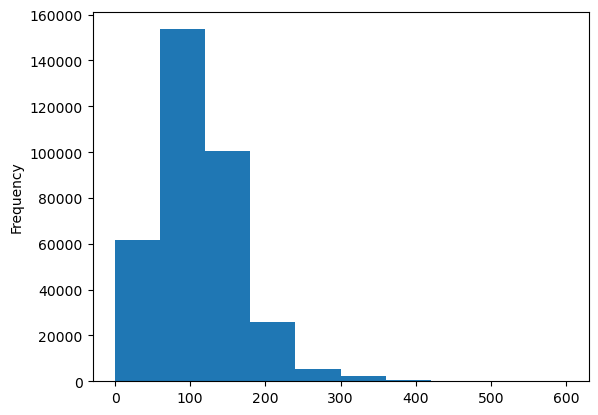

In [627]:
data.Power.plot.hist(range=(0,600));

In [628]:
# больше 10% всех записей имеют нулевую мощность двигателя

data.Power.value_counts().sort_index().head()

0    38497
1       25
2        9
3        1
4        6
Name: Power, dtype: int64

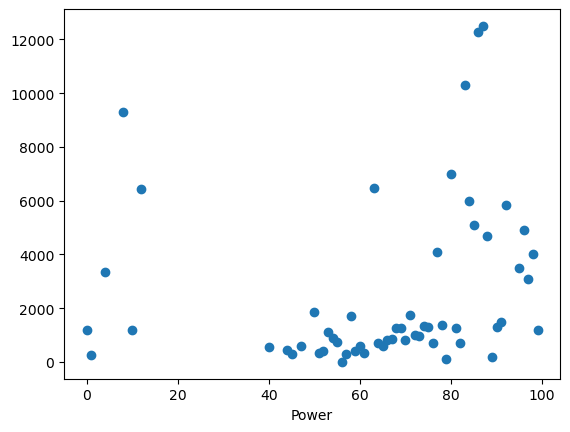

In [629]:
data.query("Power < 100 and Model == 'golf'").groupby('Power').Price.median().plot(style='o');

In [630]:
data.shape

(350355, 22)

In [631]:
# Удаляю записи с нулевой мощностью
data = data[data.Power != 0]
data.shape

(311858, 22)

In [636]:
data.Power.value_counts().sort_index().head()

1    25
2     9
3     1
4     6
5    15
Name: Power, dtype: int64

In [637]:
# количество авто с мощностью меньше 25 и мощностью больше 400

len(data.query('Power < 25')), len(data.query('Power > 400'))

(260, 709)

In [638]:
# Удаляю данные ввиду их малочисленности

data = data.query('Power >= 25 & Power <= 400')

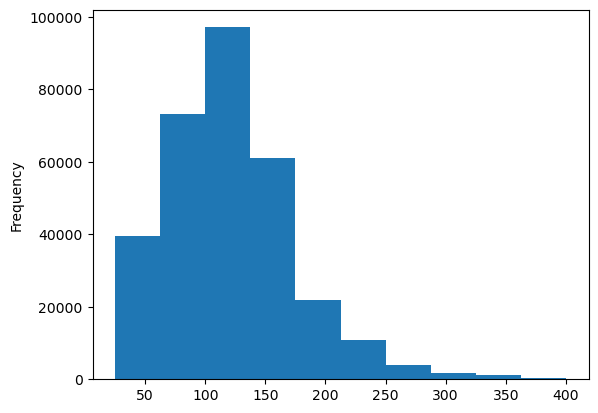

In [639]:
data.Power.plot.hist();

In [640]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 310889 entries, 1 to 354368
Data columns (total 22 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        310889 non-null  datetime64[ns]
 1   Price              310889 non-null  int64         
 2   VehicleType        310889 non-null  object        
 3   RegistrationYear   310889 non-null  int64         
 4   Gearbox            310889 non-null  object        
 5   Power              310889 non-null  int64         
 6   Model              310889 non-null  object        
 7   Kilometer          310889 non-null  int64         
 8   RegistrationMonth  310889 non-null  int64         
 9   FuelType           290031 non-null  object        
 10  Brand              310889 non-null  object        
 11  Repaired           261822 non-null  object        
 12  DateCreated        310889 non-null  datetime64[ns]
 13  NumberOfPictures   310889 non-null  int64   

### Kilometer

In [641]:
# Доли автомобилей в базе в зависимости от пробега

data.Kilometer.value_counts(normalize=True).sort_index(ascending=False)

150000    0.669856
125000    0.106501
100000    0.042369
90000     0.034060
80000     0.029856
70000     0.025466
60000     0.022220
50000     0.018447
40000     0.014603
30000     0.012696
20000     0.010714
10000     0.002917
5000      0.010293
Name: Kilometer, dtype: float64

Т.е. данные заносились в базу с определенным шагом.  
Минимум (0.02%) приходится на 10 000 км.  
Но это значение не крайнее. Есть еще 5000 км. На него приходится 1.6% данных.  
Ничего удалять не буду.

### RegistrationMonth

In [642]:
data.RegistrationMonth.value_counts(dropna=False)

3     31551
6     28729
4     26842
5     26686
7     24627
10    23863
12    22154
11    21909
9     21724
0     21715
1     20915
8     20572
2     19602
Name: RegistrationMonth, dtype: int64

Больше 10% значений с несуществующим (нулевым) месяцем.  
Оставляю как есть.

### FuelType

In [643]:
data.FuelType.value_counts(dropna=False)

petrol      194208
gasoline     90237
NaN          20858
lpg           4783
cng            498
hybrid         186
other           80
electric        39
Name: FuelType, dtype: int64

В перечне типов топлива присутствуют синонимы - `petrol` и `gasoline` но нет `diesel`

Для бренда volkswagen вывожу
* общее кол-во машин с разбивкой по 2-м видам топлива
* кол-во машин на каждом из 2-х видов топлива с разбивкой по моделям

In [644]:
data.query("(FuelType=='petrol' or FuelType=='gasoline') and Brand =='volkswagen'").FuelType.value_counts()

petrol      39509
gasoline    23422
Name: FuelType, dtype: int64

In [645]:
data.query("(FuelType=='petrol' or FuelType=='gasoline') and Brand =='volkswagen'").pivot_table(
    index='Model', columns='FuelType', values='VehicleType', aggfunc='count')

FuelType,gasoline,petrol
Model,,
amarok,15.0,NaN
beetle,116.0,620.0
bora,232.0,516.0
caddy,925.0,324.0
cc,79.0,43.0
eos,158.0,330.0
fox,51.0,572.0
golf,6538.0,18223.0
jetta,98.0,200.0


* Машин на `petrol` в 2 раза больше.
* У крупных машин (Amarok, Tiguan, Tuareg, Transporter ...) — преобладание `gasoline`
* Amarok, судя по Википедии, выпускался только с дизелем. 
В таблице: `gasoline`=16; `petrol`=0
* У мелких машин (Lupo, Polo, Beetle, Fox, ...) — преобладание `petrol`
* Маленький UP выпускался только с бензиновым мотором. В таблице: `gasoline`=1; `petrol`=321

Предполагаю, что `gasoline` — это `diesel`  
В случае с моделью UP — 1 шт на `gasoline` — ошибка.

Ничего не делаю. Оставляю как есть.

In [646]:
# Ставлю заглушку на отсутствующие значения

data.FuelType = data.FuelType.fillna('unknown')

data.FuelType.value_counts(dropna=False)

petrol      194208
gasoline     90237
unknown      20858
lpg           4783
cng            498
hybrid         186
other           80
electric        39
Name: FuelType, dtype: int64

### Repaired

In [647]:
data.Repaired.value_counts(dropna=False)

no     230887
NaN     49067
yes     30935
Name: Repaired, dtype: int64

In [648]:
# Ставлю заглушку

data.Repaired = data.Repaired.fillna('unknown')

data.Repaired.value_counts(dropna=False)

no         230887
unknown     49067
yes         30935
Name: Repaired, dtype: int64

In [649]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 310889 entries, 1 to 354368
Data columns (total 22 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        310889 non-null  datetime64[ns]
 1   Price              310889 non-null  int64         
 2   VehicleType        310889 non-null  object        
 3   RegistrationYear   310889 non-null  int64         
 4   Gearbox            310889 non-null  object        
 5   Power              310889 non-null  int64         
 6   Model              310889 non-null  object        
 7   Kilometer          310889 non-null  int64         
 8   RegistrationMonth  310889 non-null  int64         
 9   FuelType           310889 non-null  object        
 10  Brand              310889 non-null  object        
 11  Repaired           310889 non-null  object        
 12  DateCreated        310889 non-null  datetime64[ns]
 13  NumberOfPictures   310889 non-null  int64   

### NumberOfPictures

In [650]:
data.NumberOfPictures.unique()

array([0], dtype=int64)

In [651]:
# Все нули. Удаляю столбец

data = data.drop(['NumberOfPictures'], axis='columns')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 310889 entries, 1 to 354368
Data columns (total 21 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        310889 non-null  datetime64[ns]
 1   Price              310889 non-null  int64         
 2   VehicleType        310889 non-null  object        
 3   RegistrationYear   310889 non-null  int64         
 4   Gearbox            310889 non-null  object        
 5   Power              310889 non-null  int64         
 6   Model              310889 non-null  object        
 7   Kilometer          310889 non-null  int64         
 8   RegistrationMonth  310889 non-null  int64         
 9   FuelType           310889 non-null  object        
 10  Brand              310889 non-null  object        
 11  Repaired           310889 non-null  object        
 12  DateCreated        310889 non-null  datetime64[ns]
 13  PostalCode         310889 non-null  int64   

### PostalCode

In [652]:
data.PostalCode.value_counts(dropna=False)

10115    803
65428    543
66333    299
60311    265
52525    265
        ... 
86502      1
16837      1
89368      1
1778       1
95691      1
Name: PostalCode, Length: 8121, dtype: int64

Признак категориальный, номинальный. 
Т.е. не содержит свойства сортировки.  
Чтобы его корректно использовать, необходимо OHE кодировать, что приведет к очень сильному
разрастанию feature_matrix. 
Делать это не вижу смысла в виду его малой полезности для ML.


In [653]:
# Удаляю

data = data.drop(['PostalCode'], axis='columns')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 310889 entries, 1 to 354368
Data columns (total 20 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        310889 non-null  datetime64[ns]
 1   Price              310889 non-null  int64         
 2   VehicleType        310889 non-null  object        
 3   RegistrationYear   310889 non-null  int64         
 4   Gearbox            310889 non-null  object        
 5   Power              310889 non-null  int64         
 6   Model              310889 non-null  object        
 7   Kilometer          310889 non-null  int64         
 8   RegistrationMonth  310889 non-null  int64         
 9   FuelType           310889 non-null  object        
 10  Brand              310889 non-null  object        
 11  Repaired           310889 non-null  object        
 12  DateCreated        310889 non-null  datetime64[ns]
 13  LastSeen           310889 non-null  datetime

### Целевой признак

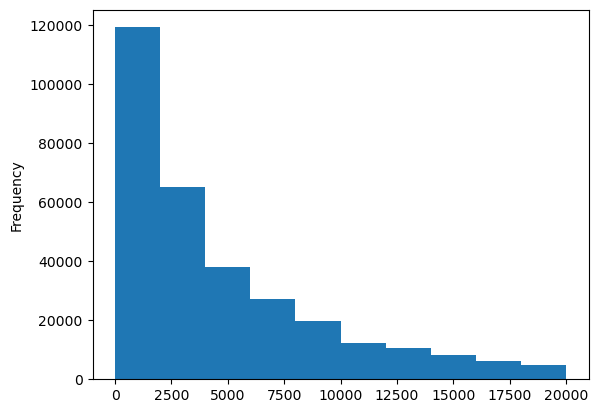

In [654]:
data.Price.plot.hist();

In [655]:
data.Price.value_counts()

0        6760
1500     4612
500      4573
1200     3907
2500     3815
         ... 
233         1
11080       1
16340       1
873         1
10985       1
Name: Price, Length: 3600, dtype: int64

In [656]:
data.shape

(310889, 20)

In [657]:
# Удаляю строки с нулевой ценой

data = data[data.Price !=0]
data.shape

(304129, 20)

In [658]:
# Кол-во записей с околонулевыми ценами.

data[data.Price < 100].Price.value_counts(bins=range(0,100,10)).sort_index()

(-0.001, 10.0]    729
(10.0, 20.0]       19
(20.0, 30.0]       21
(30.0, 40.0]       15
(40.0, 50.0]      158
(50.0, 60.0]       29
(60.0, 70.0]       38
(70.0, 80.0]      100
(80.0, 90.0]       29
Name: Price, dtype: int64

In [659]:
# Удаляю записи с ценами <= 10

data = data[data.Price > 10]
data.shape

(303400, 20)

### Object -> Category

Меняю тип категориальных данных, чтобы в дальнейшем LightGBM могла их обработать встроенными средствами.

In [660]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 303400 entries, 1 to 354368
Data columns (total 20 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        303400 non-null  datetime64[ns]
 1   Price              303400 non-null  int64         
 2   VehicleType        303400 non-null  object        
 3   RegistrationYear   303400 non-null  int64         
 4   Gearbox            303400 non-null  object        
 5   Power              303400 non-null  int64         
 6   Model              303400 non-null  object        
 7   Kilometer          303400 non-null  int64         
 8   RegistrationMonth  303400 non-null  int64         
 9   FuelType           303400 non-null  object        
 10  Brand              303400 non-null  object        
 11  Repaired           303400 non-null  object        
 12  DateCreated        303400 non-null  datetime64[ns]
 13  LastSeen           303400 non-null  datetime

In [661]:
# Список названиий столбцов с категориальными признаками
categorical = data.select_dtypes('object').columns.to_list()

data[categorical] = data[categorical].astype('category')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 303400 entries, 1 to 354368
Data columns (total 20 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        303400 non-null  datetime64[ns]
 1   Price              303400 non-null  int64         
 2   VehicleType        303400 non-null  category      
 3   RegistrationYear   303400 non-null  int64         
 4   Gearbox            303400 non-null  category      
 5   Power              303400 non-null  int64         
 6   Model              303400 non-null  category      
 7   Kilometer          303400 non-null  int64         
 8   RegistrationMonth  303400 non-null  int64         
 9   FuelType           303400 non-null  category      
 10  Brand              303400 non-null  category      
 11  Repaired           303400 non-null  category      
 12  DateCreated        303400 non-null  datetime64[ns]
 13  LastSeen           303400 non-null  datetime

### Деление на выборки

Из выборки также удаляю три столбца с датами, т.к. эти данные уже перенесены в другие столбцы

In [662]:
# использую соотношение по умолчанию = 75:25

X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['Price', 'DateCrawled', 'DateCreated', 'LastSeen'], axis=1), 
    data.Price, random_state=123)

In [663]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 227550 entries, 246888 to 291139
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   VehicleType        227550 non-null  category
 1   RegistrationYear   227550 non-null  int64   
 2   Gearbox            227550 non-null  category
 3   Power              227550 non-null  int64   
 4   Model              227550 non-null  category
 5   Kilometer          227550 non-null  int64   
 6   RegistrationMonth  227550 non-null  int64   
 7   FuelType           227550 non-null  category
 8   Brand              227550 non-null  category
 9   Repaired           227550 non-null  category
 10  DateCrawled_year   227550 non-null  int64   
 11  DateCrawled_month  227550 non-null  int64   
 12  DateCreated_year   227550 non-null  int64   
 13  DateCreated_month  227550 non-null  int64   
 14  LastSeen_year      227550 non-null  int64   
 15  LastSeen_month     227550 non

## Обучение моделей и анализ моделей

Использую GridSearchCV для обучения с подбором параметров

### CatBoostRegressor

In [665]:
param_grid = {'depth': [2, 3],
              'learning_rate': [0.4, 0.6],
              'iterations': [30, 60]}

model = CatBoostRegressor(loss_function='RMSE', logging_level='Silent', 
                          cat_features=[0,2,4,7,8,9],
                          random_state=123)

gridsearch_CB = GridSearchCV(model, param_grid, scoring='neg_root_mean_squared_error', n_jobs=-1)
gridsearch_CB.fit(X_train, y_train)

# Сохраняю лучшую модель
model_CB = gridsearch_CB.best_estimator_

Функция для вывода и форматирования результатов работы GridSearchCV

In [666]:
def results_CB(gridsearch):
    
    # DataFrame с результатами подбора параметров
    results = pd.DataFrame(gridsearch.cv_results_).iloc[:,[0,2,4,5,6,13,15]]
    # новые названия столбцов
    results.columns = ['fit_time','score_time','depth','iterations','learn_rate','RMSE','score']
    # сортировка по test_score
    results = results.sort_values('score').reset_index(drop=True).round(3)
    # neg_RMSE to RMSE
    results.RMSE = -1 * results.RMSE.round().astype('int')
    # меняю порядок столбцов
    results = results.reindex(['score','depth','learn_rate','iterations','fit_time','score_time','RMSE'], axis=1)
    # столбцы с процентной разницой относительно лучшего результата
    for col in ['fit_time','score_time', 'RMSE']:
        results[col+' delta %'] = (
            ((results[col] - results.loc[0, col]) / results.loc[0, col] *100).round(1)  )
    # столбец с результатом становится индексом
    results = results.set_index('score', drop=True)
    # МультиИндекс
    col = pd.MultiIndex.from_tuples([
    ('Learning Parameters','depth'),('Learning Parameters','learn_rate'),('Learning Parameters','iterations'), 
    ('Results','fit_time'),('Results','score_time'),('Results','RMSE'), 
    ('Delta % from the best','fit_time'),('Delta % from the best','score_time'),('Delta % from the best','RMSE')])
    results.columns = col
    return results

Результаты обучения

In [667]:
results_CB(gridsearch_CB)

Learning Parameters                        Results                   \
                    depth learn_rate iterations fit_time score_time  RMSE   
score                                                                       
1                       3        0.6         60    9.730      0.058  1793   
2                       3        0.4         60   12.865      0.114  1814   
3                       2        0.6         60    9.463      0.141  1889   
4                       3        0.6         30    7.178      0.130  1890   
5                       3        0.4         30    6.494      0.140  1914   
6                       2        0.4         60    9.456      0.124  1918   
7                       2        0.6         30    5.459      0.152  2007   
8                       2        0.4         30    5.600      0.150  2047   

      Delta % from the best                   
                   fit_time score_time  RMSE  
score                                         
1                       0.0        0.0   0.0  
2                      32.2       96.6   1.2  
3                      -2.7      143.1   5.4  
4                     -26.2      124.1   5.4  
5                     -33.3      141.4   6.7  
6                      -2.8      113.8   7.0  
7                     -43.9      162.1  11.9  
8                     -42.4      158.6  14.2

При повторении вычислений, `RMSE` не меняется, а `fit_time` и `score_time` скачут.   
Результаты ниже — среднее 4-х прогонов GridSearchCV.

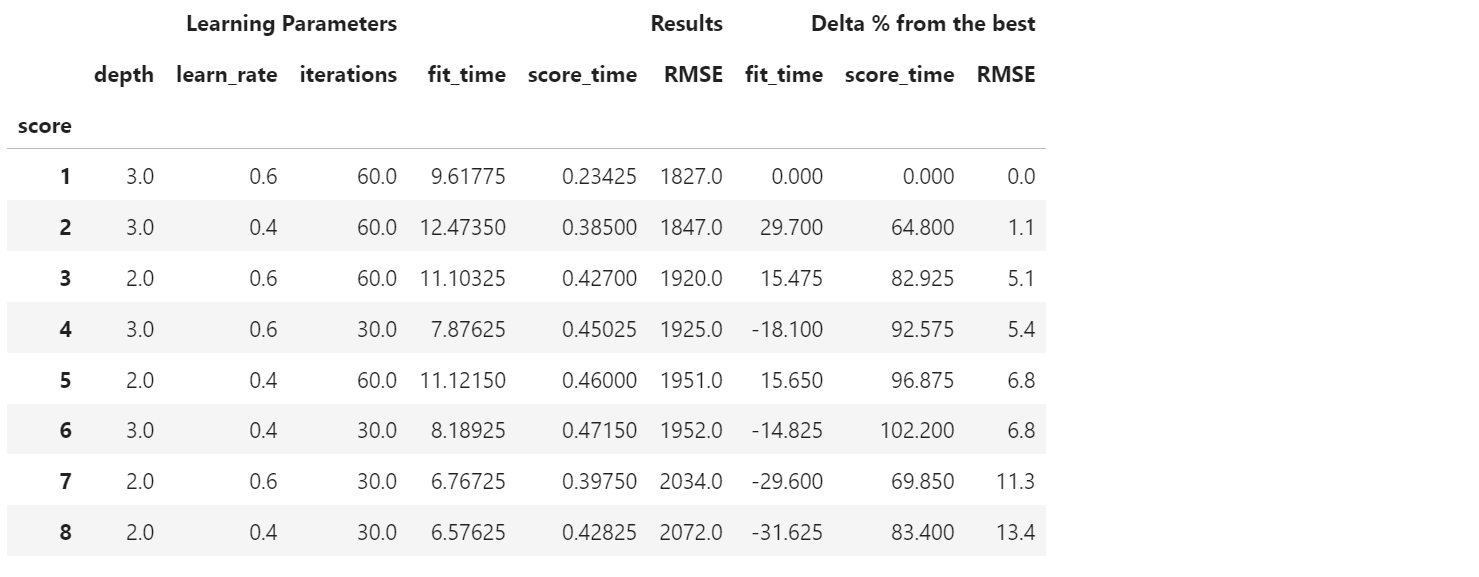

Таблица с результатами `best-worst` по каждому критерию оценки

In [668]:
results_CB = pd.DataFrame(
    columns=['depth', 'learn_rate', 'iterations','', 'RMSE', 'fit_time', 'score_time'])
results_CB.loc[0] = ['max', 'max', 'max','', 'best', '', 'best']
results_CB.loc[1] = ['min', 'min', 'min','', 'worst', 'best', '']
results_CB.loc[2] = ['max', 'min', 'max','', '', 'worst', '']
results_CB.loc[2] = ['max', 'min', 'min','', '', 'worst', 'worst']
results_CB

,depth,learn_rate,iterations,,RMSE,fit_time,score_time
0,max,max,max,,best,,best
1,min,min,min,,worst,best,
2,max,min,min,,,worst,worst


### LGBMRegressor

In [669]:
param_grid = {'max_depth': [2, 3],
              'learning_rate': [0.4, 0.6],
              'n_estimators': [30, 60]}

model = LGBMRegressor(random_state=123)

gridsearch_LGBM = GridSearchCV(model, param_grid, scoring='neg_root_mean_squared_error', n_jobs=-1)
gridsearch_LGBM.fit(X_train, y_train)

# Сохраняю лучшую модель
model_LGBM = gridsearch_LGBM.best_estimator_

Функция для вывода и форматирования результатов работы GridSearchCV

In [670]:
def results_LGBM(gridsearch):
    
    # DataFrame с результатами подбора параметров
    results = pd.DataFrame(gridsearch.cv_results_).iloc[:,[0,2,4,5,6,13,15]]
    # новые названия столбцов
    results.columns = ['fit_time','score_time','learn_rate','depth','estimators','RMSE','score']
    # сортировка по test_score
    results = results.sort_values('score').reset_index(drop=True).round(3)
    # neg_RMSE to RMSE
    results.RMSE = -1 * results.RMSE.round().astype('int')
    # меняю порядок столбцов
    results = results.reindex(['score','depth','learn_rate','estimators','fit_time','score_time','RMSE'], axis=1)
    # столбцы с процентной разницой относительно лучшего результата
    for col in ['fit_time','score_time', 'RMSE']:
        results[col+' delta %'] = (
            ((results[col] - results.loc[0, col]) / results.loc[0, col] *100).round(1)  )
    # столбец с результатом становится индексом
    results = results.set_index('score', drop=True)
    # МультиИндекс
    col = pd.MultiIndex.from_tuples([
    ('Learning Parameters', 'depth'),('Learning Parameters','learn_rate'),('Learning Parameters','estimators'), 
    ('Results', 'fit_time'), ('Results', 'score_time'), ('Results', 'RMSE'), 
    ('Delta % from the best','fit_time'),('Delta % from the best','score_time'),('Delta % from the best','RMSE')])
    results.columns = col
    return results

Результаты обучения

In [671]:
results_LGBM(gridsearch_LGBM)

Learning Parameters                        Results                   \
                    depth learn_rate estimators fit_time score_time  RMSE   
score                                                                       
1                       3        0.6         60    1.304      0.109  1703   
2                       3        0.4         60    2.221      0.237  1703   
3                       3        0.4         30    1.859      0.152  1784   
4                       3        0.6         30    1.407      0.120  1786   
5                       2        0.6         60    1.704      0.184  1792   
6                       2        0.4         60    2.108      0.250  1809   
7                       2        0.6         30    1.415      0.129  1902   
8                       2        0.4         30    1.586      0.132  1912   

      Delta % from the best                   
                   fit_time score_time  RMSE  
score                                         
1                       0.0        0.0   0.0  
2                      70.3      117.4   0.0  
3                      42.6       39.4   4.8  
4                       7.9       10.1   4.9  
5                      30.7       68.8   5.2  
6                      61.7      129.4   6.2  
7                       8.5       18.3  11.7  
8                      21.6       21.1  12.3

Среднее по 4-м прогонам GridSearchCV:

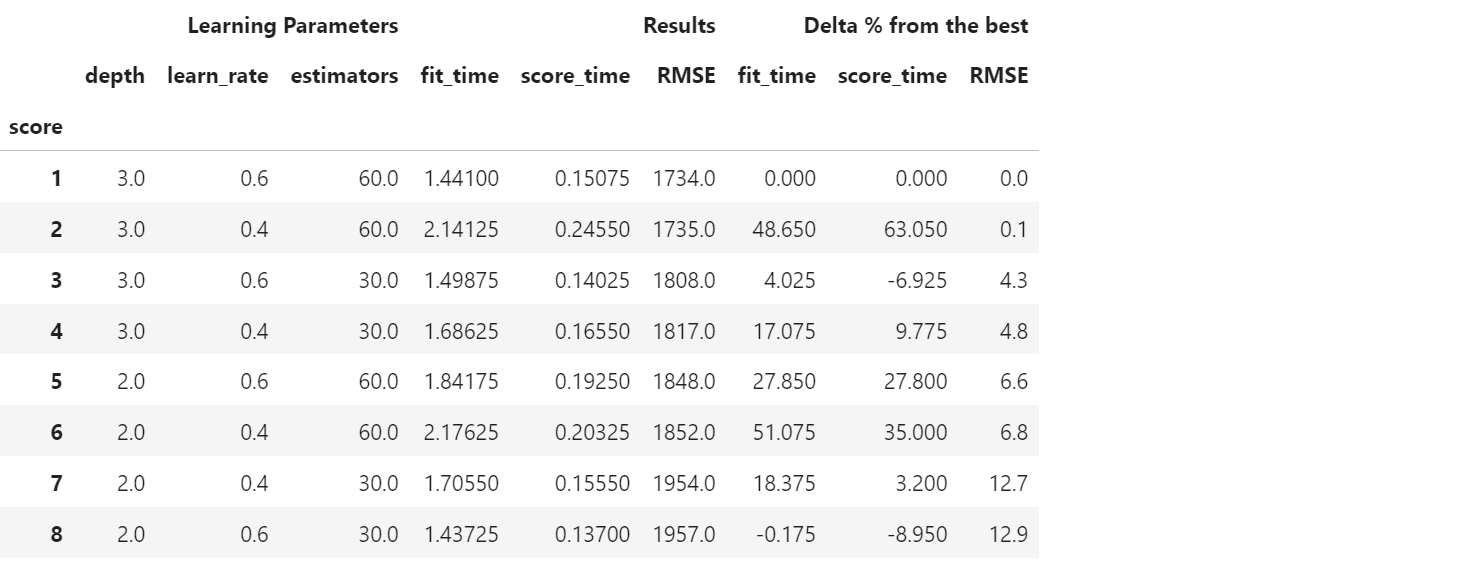

Сводная таблица с результатами `best-worst` по каждому критерию оценки

In [672]:
results_LGBM = pd.DataFrame(
    columns=['depth', 'learn_rate', 'iterations','', 'RMSE', 'fit_time', 'score_time'])
results_LGBM.loc[0] = ['max', 'max', 'max','', 'best', '', '']
results_LGBM.loc[1] = ['min', 'max', 'min','', 'worst', 'best', 'best']
results_LGBM.loc[2] = ['max', 'min', 'max','', '', 'worst', 'worst']

results_LGBM

,depth,learn_rate,iterations,,RMSE,fit_time,score_time
0,max,max,max,,best,,
1,min,max,min,,worst,best,best
2,max,min,max,,,worst,worst


### RandomForestRegressor

In [673]:
# Списки названиий столбцов с категориальными и данными
categorical = X_train.select_dtypes('category').columns.to_list()

oe_encoder = OrdinalEncoder()

# объект для кодирования каегориальных признаков без затрагивания числовых
preprocessor = ColumnTransformer([('oe', oe_encoder, categorical)], remainder='passthrough')

# кодирование признаков
preprocessor.fit(X_train)
X_train_RFR = preprocessor.transform(X_train)
X_test_RFR = preprocessor.transform(X_test)

In [674]:
param_grid = {'max_depth': [2, 3],
              'min_samples_split': [2, 3],
              'n_estimators': [30, 60]}

model = RandomForestRegressor(random_state=123)

gridsearch_RFR = GridSearchCV(model, param_grid, scoring='neg_root_mean_squared_error', n_jobs=-1)
gridsearch_RFR.fit(X_train_RFR, y_train)

# Сохраняю лучшую модель
model_RFR = gridsearch_RFR.best_estimator_

Функция для вывода и форматирования результатов работы GridSearchCV

In [675]:
def results_RFR(gridsearch):
    
    # DataFrame с результатами подбора параметров
    results = pd.DataFrame(gridsearch.cv_results_).iloc[:,[0,2,4,5,6,13,15]]
    # новые названия столбцов
    results.columns = ['fit_time','score_time','depth','samp_split','estimators','RMSE','score']
    # сортировка по test_score
    results = results.sort_values('score').reset_index(drop=True).round(3)
    # neg_RMSE to RMSE
    results.RMSE = -1 * results.RMSE.round().astype('int')
    # меняю порядок столбцов
    results = results.reindex(['score','depth','samp_split','estimators','fit_time','score_time','RMSE'], axis=1)
    # столбцы с процентной разницой относительно лучшего результата
    for col in ['fit_time','score_time', 'RMSE']:
        results[col+' delta %'] = (
            ((results[col] - results.loc[0, col]) / results.loc[0, col] *100).round(1)  )
    # столбец с результатом становится индексом
    results = results.set_index('score', drop=True)
    # МультиИндекс
    col = pd.MultiIndex.from_tuples([
    ('Learning Parameters', 'depth'),('Learning Parameters','samp_split'),('Learning Parameters','estimators'), 
    ('Results', 'fit_time'), ('Results', 'score_time'), ('Results', 'RMSE'), 
    ('Delta % from the best','fit_time'),('Delta % from the best','score_time'),('Delta % from the best','RMSE')])
    results.columns = col
    return results

In [676]:
results_RFR(gridsearch_RFR)

Learning Parameters                        Results                   \
                    depth samp_split estimators fit_time score_time  RMSE   
score                                                                       
1                       3          2         60   33.871      0.116  2929   
1                       3          3         60   20.647      0.085  2929   
3                       3          2         30   18.742      0.070  2930   
3                       3          3         30   18.432      0.074  2930   
5                       2          2         30   13.448      0.066  3236   
5                       2          3         30   13.915      0.066  3236   
7                       2          2         60   27.742      0.117  3236   
7                       2          3         60   26.226      0.118  3236   

      Delta % from the best                   
                   fit_time score_time  RMSE  
score                                         
1                       0.0        0.0   0.0  
1                     -39.0      -26.7   0.0  
3                     -44.7      -39.7   0.0  
3                     -45.6      -36.2   0.0  
5                     -60.3      -43.1  10.5  
5                     -58.9      -43.1  10.5  
7                     -18.1        0.9  10.5  
7                     -22.6        1.7  10.5

Не стал находить среднее по 4-м вычислениям ввиду длительного времени обучения.  
Модель не достигла нужного порога качества (2500)

### Выбор лучшей модели

`RandomForestRegressor` отпадает.
* Порог качества (2500) не достигнут.
* Время обучения в 3 раза дольше чем у конкурентов (6.5 сек vs 2.0)


`CatBoostRegressor`

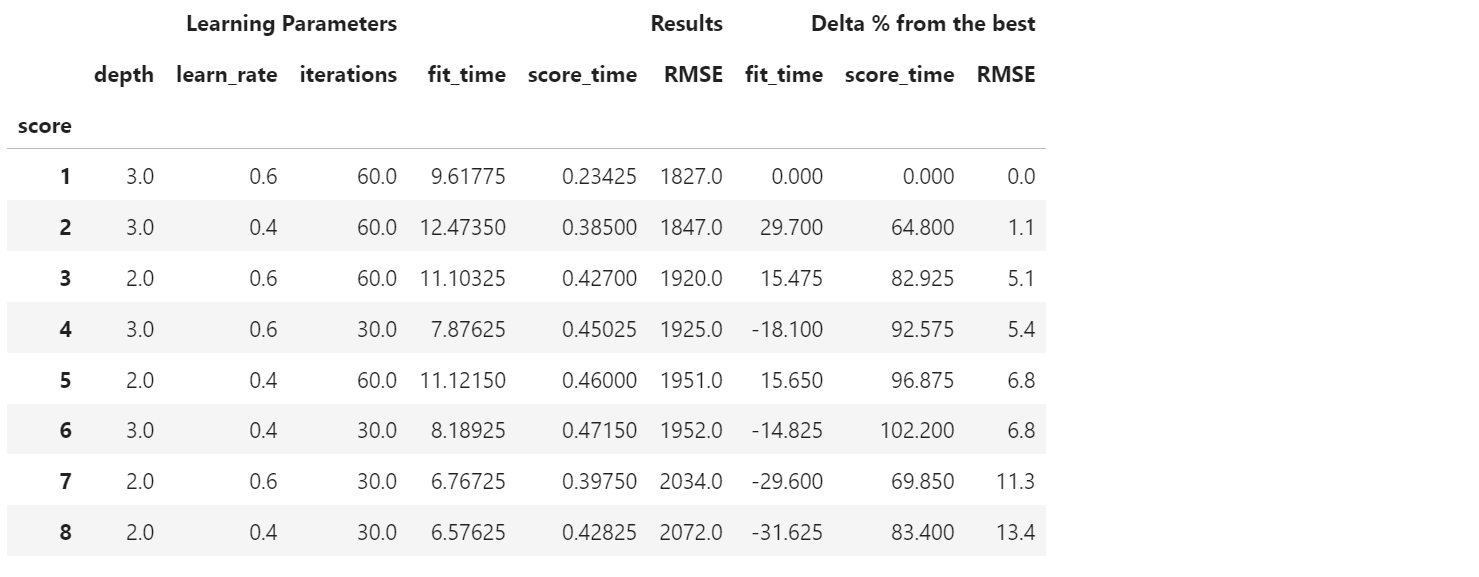

`LGBMRegressor`

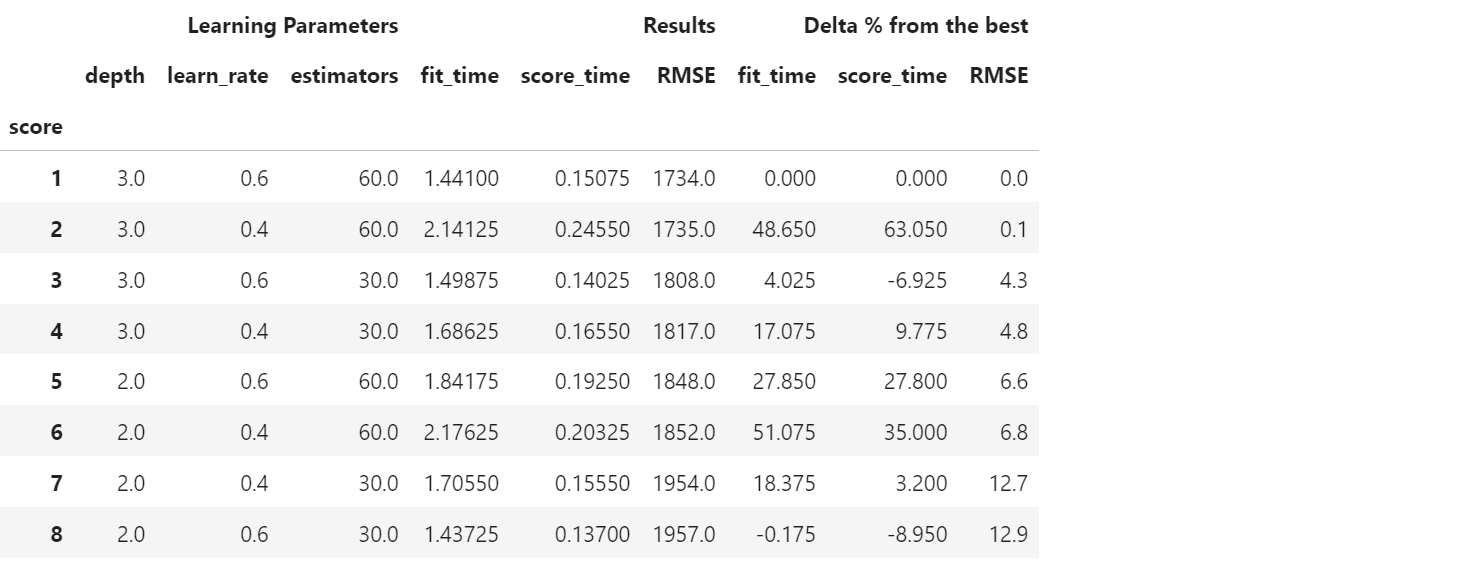

`LGBMRegressor` vs `CatBoostRegressor`
* Лучше качество 1734 vs 1827;
* Меньше время обучения 1.4 vs 9.6;
* Меньше время предсказания 0.15 vs 0.23

Победитель — `LGBMRegressor`

### Проверка на тестовой выборке

In [677]:
y_predict = model_LGBM.predict(X_test)

mean_squared_error(y_test, y_predict)**0.5

1709.2608235753842

Достигнутый результат в 1-й версии проекта - 1910.7  
Достигнутый результат во 2-й версии проекта - 1790.3  

Требование по качеству выполнено

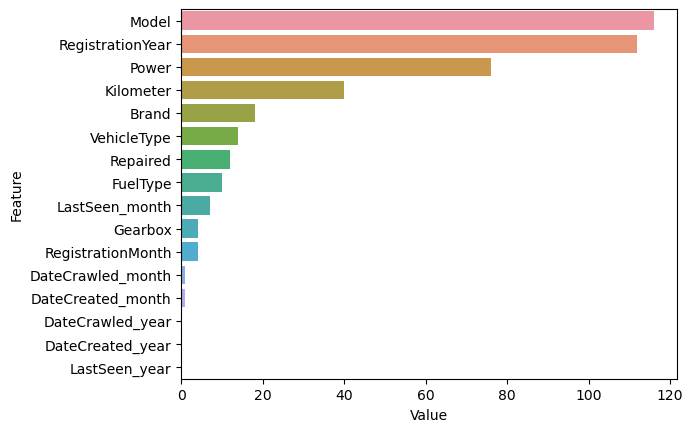

In [678]:
import seaborn as sns
feature_importance = model_LGBM.feature_importances_
feature_imp = pd.DataFrame(zip(feature_importance, X_train.columns), columns=['Value','Feature'])
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False));